In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import copy
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Версии библиотек
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

PyTorch: 2.9.0+cu128
Torchvision: 0.24.0+cu128
NumPy: 2.3.4
Matplotlib: 3.10.7


## Установка Seed

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Аугментация данных

In [4]:
class TwoTransform:
    # Возвращает две разные версии одного изображеня
    def __init__(self, base_transform):
        self.base = base_transform
    def __call__(self, x):
        return self.base(x), self.base(x)

# Сдвиг, кадрирование, поворот и нормализация

# Для обучения BYOL
mnist_aug = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mean и std пикселей на MNIST
])

# Для проверки линейной головы
linear_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Пример исходного и аугментированных изображений

In [5]:
mnist_ds = datasets.MNIST(root='./data', train=True, transform=None, download=True)

In [6]:
img, label = mnist_ds[0]
v1, v2 = TwoTransform(mnist_aug)(img)

def unnormalize(tensor):
    return tensor * 0.3081 + 0.1307

v1_img = unnormalize(v1).squeeze().numpy()
v2_img = unnormalize(v2).squeeze().numpy()
orig_img = transforms.ToTensor()(img).squeeze().numpy() 

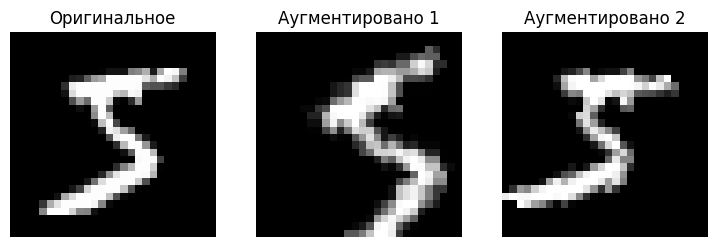

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))
axes[0].imshow(orig_img, cmap='gray')
axes[0].set_title("Оригинальное")
axes[1].imshow(v1_img, cmap='gray')
axes[1].set_title("Аугментировано 1")
axes[2].imshow(v2_img, cmap='gray')
axes[2].set_title("Аугментировано 2")
for ax in axes:
    ax.axis('off')
plt.show()

## Энкодер

In [8]:
class Encoder(nn.Module):
    def __init__(self, rep_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), # 28x28
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), # 14x14
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), # 7x7
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten() # 1x1
        )
        self.fc = nn.Linear(128, rep_dim) # 1x1x128 -> 128
    def forward(self, x): return self.fc(self.net(x))

## Проекционная и предикторные головы

In [9]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x): return self.net(x)

## BYOL модель

In [10]:
class BYOL:
    def __init__(self, encoder, projector_dim, pred_hidden, tau):
        # Энкодер ученика
        self.student_encoder = encoder
        # Проекционная голова ученика
        self.student_projector = MLP(encoder.fc.out_features, pred_hidden, projector_dim)
        # Предикторная голова ученика (Без нее не сходится( )

        # Энкодер и голова учителя (одинаковое состояние)
        self.student_predictor = MLP(projector_dim, pred_hidden, projector_dim)
        self.teacher_encoder = copy.deepcopy(encoder)
        self.teacher_projector = copy.deepcopy(self.student_projector)
        # Замороска параметров учителя (обновление только через EMA)
        self._set_requires_grad(self.teacher_encoder, False)
        self._set_requires_grad(self.teacher_projector, False)
        self.teacher_encoder.eval()
        self.teacher_projector.eval()
        self.tau = tau
    @staticmethod
    def _set_requires_grad(model, req):
        # Выключает градиенты для всех параметров модели
        for p in model.parameters(): p.requires_grad = req
    def to(self, device):
        self.student_encoder.to(device)
        self.student_projector.to(device)
        self.student_predictor.to(device)
        self.teacher_encoder.to(device)
        self.teacher_projector.to(device)
    def student_forward(self, x):
        y = self.student_encoder(x)
        z = self.student_projector(y)
        p = self.student_predictor(z)
        return y, z, p
    @torch.no_grad()
    def teacher_forward(self, x):
        y = self.teacher_encoder(x)
        z = self.teacher_projector(y)
        return y, z
    @torch.no_grad()
    def update_teacher(self):
        # Обновление для параметров
        for param_q, param_k in zip(self.student_encoder.parameters(), self.teacher_encoder.parameters()):
            param_k.mul_(self.tau).add_(param_q, alpha=1.0 - self.tau)
        for param_q, param_k in zip(self.student_projector.parameters(), self.teacher_projector.parameters()):
            param_k.mul_(self.tau).add_(param_q, alpha=1.0 - self.tau)

        # Обновление для буферов BatchNorm
        for m_s, m_t in zip(self.student_encoder.modules(), self.teacher_encoder.modules()):
            if isinstance(m_s, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
                m_t.running_mean.mul_(self.tau).add_(m_s.running_mean, alpha=1.0 - self.tau)
                m_t.running_var.mul_(self.tau).add_(m_s.running_var, alpha=1.0 - self.tau)

        for m_s, m_t in zip(self.student_projector.modules(), self.teacher_projector.modules()):
            if isinstance(m_s, (nn.BatchNorm1d, nn.BatchNorm2d)):
                m_t.running_mean.mul_(self.tau).add_(m_s.running_mean, alpha=1.0 - self.tau)
                m_t.running_var.mul_(self.tau).add_(m_s.running_var, alpha=1.0 - self.tau)

def byol_loss(p, z_target):
    # Приближение двух аугментаций (косинусное сходство)
    p = F.normalize(p, dim=-1)
    z = F.normalize(z_target, dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1)

## Функции для проверки коллапса

In [11]:
def make_collapse_loader(n_samples=512):
    ds = datasets.MNIST(root='./data', train=True, transform=linear_aug, download=True)
    subset_idx = torch.randperm(len(ds))[:n_samples]
    subset = torch.utils.data.Subset(ds, subset_idx)
    loader = DataLoader(subset, batch_size=256, shuffle=False)
    return loader

@torch.no_grad()
def compute_trace_cov(encoder, loader, device):
    encoder.eval()
    feats = []

    for x, _ in loader:
        x = x.to(device)
        y = encoder(x)
        feats.append(y.cpu())

    feats = torch.cat(feats, dim=0)

    # центрируем
    mu = feats.mean(dim=0, keepdim=True)
    X = feats - mu

    # ковариация
    cov = (X.T @ X) / (X.size(0) - 1)

    return torch.trace(cov).item()


## Цикл обучения BYOL

In [12]:
def train_byol(byol, dataloader, optimizer, device, epochs, tau):
    byol.tau = tau
    byol.to(device)

    loss_list = []
    trace_list = []

    collapse_loader = make_collapse_loader()

    for epoch in range(1, epochs+1):

        byol.student_encoder.train()
        byol.student_projector.train()
        byol.student_predictor.train()

        byol.teacher_encoder.eval()
        byol.teacher_projector.eval()

        current_epoch = 0.0

        for (x1, x2), _ in tqdm(dataloader, desc=f"BYOL epoch {epoch}/{epochs}"):
            x1, x2 = x1.to(device), x2.to(device)
            _, z1, p1 = byol.student_forward(x1)
            _, z2, p2 = byol.student_forward(x2)
            with torch.no_grad():
                _, z1_t = byol.teacher_forward(x1)
                _, z2_t = byol.teacher_forward(x2)
            loss = (byol_loss(p1, z2_t).mean() + byol_loss(p2, z1_t).mean()) * 0.5
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            byol.update_teacher()
            current_epoch += loss.item() * x1.size(0)
        avg_loss = current_epoch / len(dataloader.dataset)
        loss_list.append(avg_loss)

        # Коллапс чек
        trace_val = compute_trace_cov(byol.student_encoder, collapse_loader, device)
        trace_list.append(trace_val)

        print(f"Epoch {epoch}: BYOL loss = {avg_loss:.4f}, trace(cov) = {trace_val:.2f}")
    return loss_list, trace_list

## Цикл обучения линейной головы

In [13]:
def train_linear(encoder, train_loader, test_loader, device, epochs, lr):
    encoder.eval()
    # Заморозка всех параметров энкодера
    for p in encoder.parameters(): p.requires_grad = False
    feat_dim = encoder.fc.out_features
    linear = nn.Linear(feat_dim, 10).to(device)
    opt = torch.optim.Adam(linear.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    acc_list = []
    for epoch in range(1, epochs+1):
        linear.train(); current = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad(): feats = encoder(x)
            logits = linear(feats)
            loss = criterion(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
            current += loss.item() * x.size(0)
        avg = current / len(train_loader.dataset)
        acc = evaluate_encoder_linear(encoder, linear, test_loader, device)
        acc_list.append(acc)
        print(f"Linear eval epoch {epoch}: loss={avg:.4f}, acc={acc:.2f}%")
    return linear, acc_list

## Оценка точности линейной головы

In [14]:
def evaluate_encoder_linear(encoder, linear, test_loader, device):
    encoder.eval(); linear.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            preds = linear(feats).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

## Загрузка MNIST и применение аугментаций

In [15]:
class MNISTTwoView(datasets.MNIST):
    def __init__(self, root, train, transform, download):
        super().__init__(root=root, train=train, transform=None, download=download)
        self.twotransform = transform
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        v1, v2 = self.twotransform(img)
        return (v1, v2), target

def make_dataloaders(batch_size_pretrain=256, batch_size_eval=256, seed=42):
    g = torch.Generator().manual_seed(seed)

    # Для обучения BYOL
    pretrain_ds = MNISTTwoView(root='./data', train=True, transform=TwoTransform(mnist_aug), download=True)
    pretrain_loader = DataLoader(pretrain_ds, batch_size=batch_size_pretrain, shuffle=True, num_workers=0, drop_last=True, generator=g)

    # Для обучения и тестирования линейной головы
    train_ds = datasets.MNIST(root='./data', train=True, transform=linear_aug, download=True)
    test_ds = datasets.MNIST(root='./data', train=False, transform=linear_aug, download=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size_eval, shuffle=True, num_workers=0, generator=g) # Винда
    test_loader = DataLoader(test_ds, batch_size=batch_size_eval, shuffle=False, num_workers=0)

    return pretrain_loader, train_loader, test_loader

## Параметры

In [16]:
pretrain_epochs = 25
linear_epochs = 50
tau = 0.999

In [17]:
pretrain_loader, train_loader, test_loader = make_dataloaders()
encoder = Encoder(rep_dim=128)
byol = BYOL(encoder, projector_dim=64, pred_hidden=128, tau=tau)
student_params = list(byol.student_encoder.parameters()) + list(byol.student_projector.parameters()) + list(byol.student_predictor.parameters())
optimizer = torch.optim.Adam(student_params, lr=1e-3, weight_decay=1e-6)

## Обучение BYOL

In [18]:
loss_list, trace_list = train_byol(byol, pretrain_loader, optimizer, device, epochs=pretrain_epochs, tau=tau)

BYOL epoch 1/25: 100%|██████████| 234/234 [01:19<00:00,  2.93it/s]


Epoch 1: BYOL loss = 0.0464, trace(cov) = 4.99


BYOL epoch 2/25: 100%|██████████| 234/234 [01:21<00:00,  2.88it/s]


Epoch 2: BYOL loss = 0.0012, trace(cov) = 5.53


BYOL epoch 3/25: 100%|██████████| 234/234 [01:20<00:00,  2.91it/s]


Epoch 3: BYOL loss = 0.0008, trace(cov) = 5.87


BYOL epoch 4/25: 100%|██████████| 234/234 [01:19<00:00,  2.94it/s]


Epoch 4: BYOL loss = 0.0009, trace(cov) = 5.97


BYOL epoch 5/25: 100%|██████████| 234/234 [01:19<00:00,  2.95it/s]


Epoch 5: BYOL loss = 0.0023, trace(cov) = 5.93


BYOL epoch 6/25: 100%|██████████| 234/234 [01:22<00:00,  2.84it/s]


Epoch 6: BYOL loss = 0.0102, trace(cov) = 5.13


BYOL epoch 7/25: 100%|██████████| 234/234 [01:19<00:00,  2.93it/s]


Epoch 7: BYOL loss = 0.0249, trace(cov) = 5.66


BYOL epoch 8/25: 100%|██████████| 234/234 [01:19<00:00,  2.93it/s]


Epoch 8: BYOL loss = 0.0328, trace(cov) = 5.06


BYOL epoch 9/25: 100%|██████████| 234/234 [01:20<00:00,  2.90it/s]


Epoch 9: BYOL loss = 0.0453, trace(cov) = 3.88


BYOL epoch 10/25: 100%|██████████| 234/234 [01:21<00:00,  2.88it/s]


Epoch 10: BYOL loss = 0.0592, trace(cov) = 3.78


BYOL epoch 11/25: 100%|██████████| 234/234 [01:19<00:00,  2.93it/s]


Epoch 11: BYOL loss = 0.0684, trace(cov) = 3.30


BYOL epoch 12/25: 100%|██████████| 234/234 [01:23<00:00,  2.81it/s]


Epoch 12: BYOL loss = 0.0785, trace(cov) = 3.73


BYOL epoch 13/25: 100%|██████████| 234/234 [01:21<00:00,  2.85it/s]


Epoch 13: BYOL loss = 0.0842, trace(cov) = 4.14


BYOL epoch 14/25: 100%|██████████| 234/234 [01:21<00:00,  2.88it/s]


Epoch 14: BYOL loss = 0.0883, trace(cov) = 4.07


BYOL epoch 15/25: 100%|██████████| 234/234 [01:22<00:00,  2.85it/s]


Epoch 15: BYOL loss = 0.0906, trace(cov) = 4.30


BYOL epoch 16/25: 100%|██████████| 234/234 [01:22<00:00,  2.83it/s]


Epoch 16: BYOL loss = 0.0937, trace(cov) = 4.40


BYOL epoch 17/25: 100%|██████████| 234/234 [01:23<00:00,  2.81it/s]


Epoch 17: BYOL loss = 0.0972, trace(cov) = 4.58


BYOL epoch 18/25: 100%|██████████| 234/234 [01:22<00:00,  2.82it/s]


Epoch 18: BYOL loss = 0.0996, trace(cov) = 4.50


BYOL epoch 19/25: 100%|██████████| 234/234 [01:21<00:00,  2.86it/s]


Epoch 19: BYOL loss = 0.1034, trace(cov) = 4.63


BYOL epoch 20/25: 100%|██████████| 234/234 [01:22<00:00,  2.85it/s]


Epoch 20: BYOL loss = 0.1041, trace(cov) = 5.11


BYOL epoch 21/25: 100%|██████████| 234/234 [01:20<00:00,  2.90it/s]


Epoch 21: BYOL loss = 0.1063, trace(cov) = 5.14


BYOL epoch 22/25: 100%|██████████| 234/234 [01:17<00:00,  3.01it/s]


Epoch 22: BYOL loss = 0.1090, trace(cov) = 4.17


BYOL epoch 23/25: 100%|██████████| 234/234 [01:18<00:00,  2.99it/s]


Epoch 23: BYOL loss = 0.1077, trace(cov) = 4.55


BYOL epoch 24/25: 100%|██████████| 234/234 [01:18<00:00,  2.99it/s]


Epoch 24: BYOL loss = 0.1056, trace(cov) = 4.44


BYOL epoch 25/25: 100%|██████████| 234/234 [01:17<00:00,  3.01it/s]

Epoch 25: BYOL loss = 0.1032, trace(cov) = 4.17


## Обучение линейной головы

In [19]:
frozen_encoder = byol.student_encoder
_, acc_list = train_linear(frozen_encoder, train_loader, test_loader, device, epochs=linear_epochs, lr=1e-3)

Linear eval epoch 1: loss=1.7920, acc=64.95%
Linear eval epoch 2: loss=1.3513, acc=72.60%
Linear eval epoch 3: loss=1.1410, acc=75.76%
Linear eval epoch 4: loss=1.0075, acc=77.91%
Linear eval epoch 5: loss=0.9143, acc=79.00%
Linear eval epoch 6: loss=0.8450, acc=80.82%
Linear eval epoch 7: loss=0.7913, acc=81.96%
Linear eval epoch 8: loss=0.7487, acc=82.59%
Linear eval epoch 9: loss=0.7132, acc=83.40%
Linear eval epoch 10: loss=0.6835, acc=83.78%
Linear eval epoch 11: loss=0.6583, acc=84.12%
Linear eval epoch 12: loss=0.6364, acc=84.10%
Linear eval epoch 13: loss=0.6173, acc=84.39%
Linear eval epoch 14: loss=0.6000, acc=84.73%
Linear eval epoch 15: loss=0.5849, acc=85.32%
Linear eval epoch 16: loss=0.5711, acc=85.67%
Linear eval epoch 17: loss=0.5586, acc=85.90%
Linear eval epoch 18: loss=0.5474, acc=86.01%
Linear eval epoch 19: loss=0.5366, acc=86.29%
Linear eval epoch 20: loss=0.5271, acc=86.64%
Linear eval epoch 21: loss=0.5181, acc=86.49%
Linear eval epoch 22: loss=0.5099, acc=86.5

## Обучение на случайно инициализированном энкодере

In [26]:
random_encoder = Encoder(rep_dim=128).to(device)

# Заморазка параметров энкодера (т.к. они случайные и не будут меняться)
for p in random_encoder.parameters(): 
    p.requires_grad = False

linear_random, acc_random_list = train_linear(random_encoder, train_loader, test_loader, device, epochs=linear_epochs, lr=1e-3)

print(f"Точность на случайном энкодере: {acc_random_list[-1]:.2f}%")

Linear eval epoch 1: loss=2.2735, acc=21.64%
Linear eval epoch 2: loss=2.2212, acc=26.27%
Linear eval epoch 3: loss=2.1760, acc=27.24%
Linear eval epoch 4: loss=2.1369, acc=31.49%
Linear eval epoch 5: loss=2.1024, acc=33.68%
Linear eval epoch 6: loss=2.0720, acc=32.52%
Linear eval epoch 7: loss=2.0448, acc=36.40%
Linear eval epoch 8: loss=2.0198, acc=36.13%
Linear eval epoch 9: loss=1.9973, acc=34.48%
Linear eval epoch 10: loss=1.9766, acc=38.85%
Linear eval epoch 11: loss=1.9572, acc=39.57%
Linear eval epoch 12: loss=1.9392, acc=42.47%
Linear eval epoch 13: loss=1.9223, acc=43.65%
Linear eval epoch 14: loss=1.9063, acc=41.85%
Linear eval epoch 15: loss=1.8912, acc=42.08%
Linear eval epoch 16: loss=1.8768, acc=45.86%
Linear eval epoch 17: loss=1.8631, acc=46.76%
Linear eval epoch 18: loss=1.8499, acc=46.70%
Linear eval epoch 19: loss=1.8374, acc=46.38%
Linear eval epoch 20: loss=1.8250, acc=47.10%
Linear eval epoch 21: loss=1.8135, acc=48.16%
Linear eval epoch 22: loss=1.8021, acc=49.2

## Графики процесса обучения

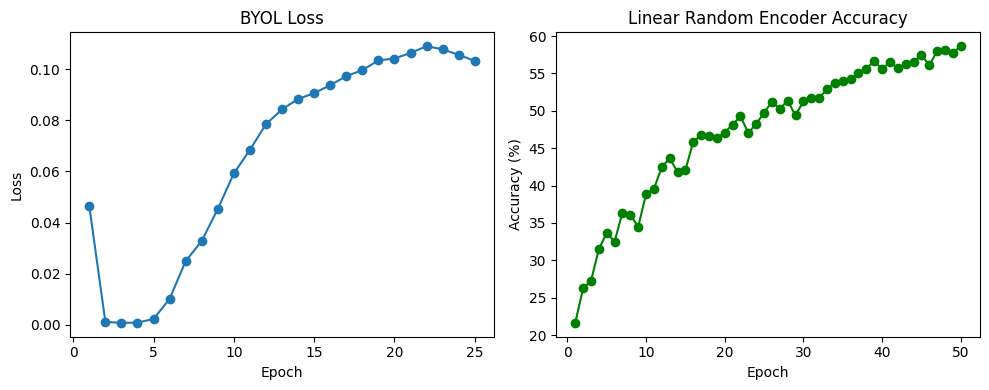

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(loss_list)+1), loss_list, marker='o')
plt.title("BYOL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, len(acc_list)+1), acc_random_list, marker='o', color='green')
plt.title("Linear Random Encoder Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.show()

## Trace Cov

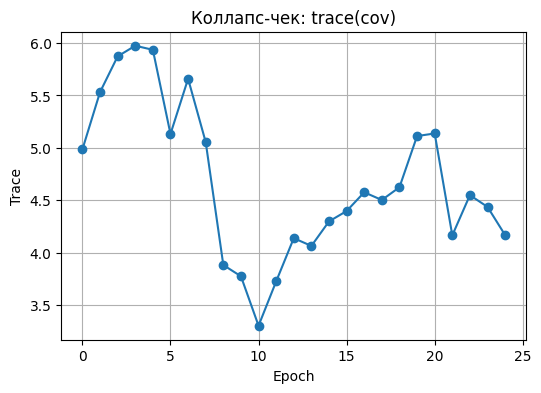

In [21]:
plt.figure(figsize=(6,4))
plt.plot(trace_list, marker='o')
plt.title("Коллапс-чек: trace(cov)")
plt.xlabel("Epoch")
plt.ylabel("Trace")
plt.grid(True)
plt.show()


## TSNE График

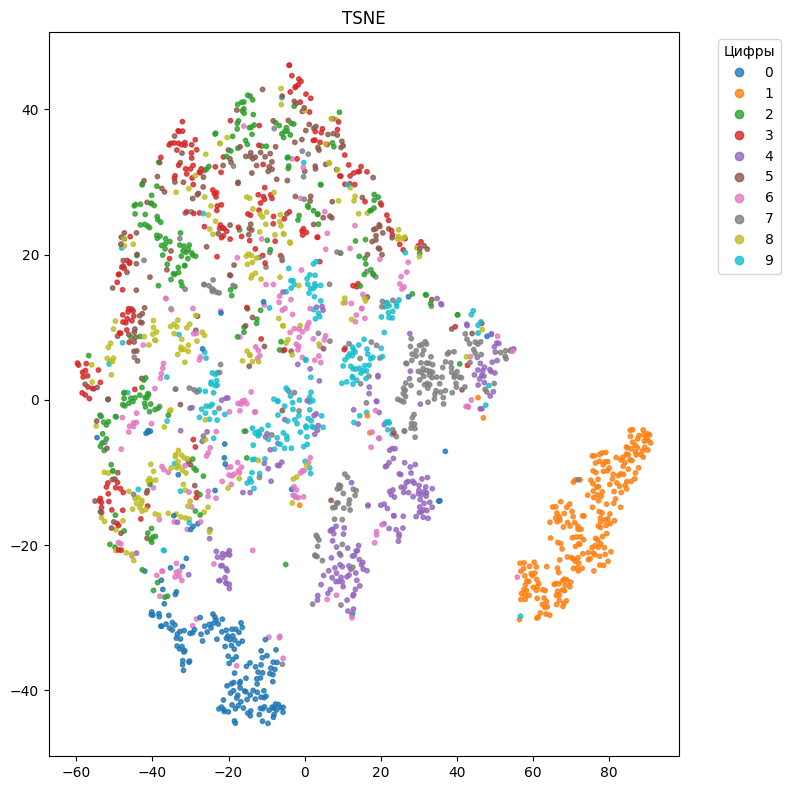

In [22]:
from sklearn.manifold import TSNE

def visualize_embeddings_tsne(encoder, dataloader, device, n_samples=2000):
    encoder.eval()
    feats_list = []
    labels_list = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            feats_list.append(feats.cpu())
            labels_list.append(y.cpu())
            if len(torch.cat(labels_list)) >= n_samples:
                break

    feats = torch.cat(feats_list)[:n_samples]
    labels = torch.cat(labels_list)[:n_samples]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    emb_2d = tsne.fit_transform(feats.numpy())

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Цифры", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("TSNE")
    plt.tight_layout()
    plt.show()

visualize_embeddings_tsne(frozen_encoder, test_loader, device)

## Матрица ошибок

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
def plot_confusion_matrix(encoder, linear, test_loader, device):
    encoder.eval()
    linear.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            preds = linear(feats).argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Матрица ошибок - BYOL")
    plt.show()


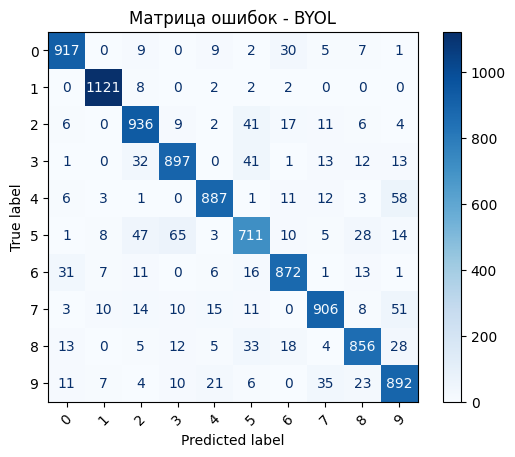

In [25]:
plot_confusion_matrix(frozen_encoder, _, test_loader, device)

## Прогон по нескольким сидам

In [29]:
import json
import os

def sweep_tau(tau_list, seeds=[42, 123, 456], pretrain_epochs=25, linear_epochs=50, save_path="tau_sweep_results.json"):
    os.makedirs("results", exist_ok=True)
    
    results = {}

    for tau in tau_list:
        acc_per_seed = []
        print(f"\n=== Tau = {tau} ===")
        for seed in seeds:
            print(f"\nSeed {seed}...")
            # Установка сида
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            # Даталоадеры
            pretrain_loader, train_loader, test_loader = make_dataloaders()

            # Модель и BYOL
            encoder = Encoder(rep_dim=128)
            byol = BYOL(encoder, projector_dim=64, pred_hidden=128, tau=tau)
            student_params = list(byol.student_encoder.parameters()) + list(byol.student_projector.parameters()) + list(byol.student_predictor.parameters())
            optimizer = torch.optim.Adam(student_params, lr=1e-3, weight_decay=1e-6)

            # Предобучение BYOL
            _ = train_byol(byol, pretrain_loader, optimizer, device, epochs=pretrain_epochs, tau=tau)

            # Линейная оценка
            frozen_encoder = byol.student_encoder
            _, acc_list = train_linear(frozen_encoder, train_loader, test_loader, device, epochs=linear_epochs, lr=1e-3)
            final_acc = acc_list[-1]  # Берем последнюю эпоху

            acc_per_seed.append(final_acc)
            print(f"Сид {seed} завершен: точность линейной головы = {final_acc:.2f}%")

        # Сохраняем результаты по tau
        mean_acc = float(np.mean(acc_per_seed))
        std_acc = float(np.std(acc_per_seed))
        results[str(tau)] = {
            "seed_accuracies": acc_per_seed,
            "mean": mean_acc,
            "std": std_acc
        }

        print(f"\nTau={tau}: mean={mean_acc:.2f}%, std={std_acc:.2f}%")

    # Сохраняем в JSON
    with open(save_path, "w") as f:
        json.dump(results, f, indent=4)

    return results


In [ ]:
tau_values = [0.98]
results = sweep_tau(tau_values, save_path="results/tau_98.json")


In [ ]:
tau_values = [0.995]
results = sweep_tau(tau_values, save_path="results/tau_995.json")


In [ ]:
tau_values = [0.999]
results = sweep_tau(tau_values, save_path="results/tau_999.json")


## Построение графика по результатам прогонов

In [ ]:
# Пути к файлам
files = {
    "0.98": "tau_98.json",
    "0.995": "tau_995.json",
    "0.999": "tau_999.json"
}

taus = []
means = []
stds = []

# Загружаем данные
for tau, path in files.items():
    with open(path, "r") as f:
        data = json.load(f)
        result = data[tau]
        taus.append(float(tau))
        means.append(result["mean"])
        stds.append(result["std"])

# Преобразуем в массивы
taus = np.array(taus)
means = np.array(means)
stds = np.array(stds)

plt.figure(figsize=(8, 5))
plt.errorbar(taus, means, yerr=stds, fmt='o-', capsize=5)
plt.title("Зависимость точности от τ")
plt.xlabel("τ")
plt.ylabel("Точность (%)")
plt.grid(True)
plt.show()

## Абляции для аугментаций

In [29]:
aug_soft = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.95, 1.0)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

aug_medium = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.85, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

aug_hard = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.7, 1.0)),
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, translate=(0.15,0.15), scale=(0.85,1.15), shear=15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [34]:
def ablation_augmentations(tau=0.98, 
                           aug_list=[('soft', aug_soft), ('med', aug_medium), ('hard', aug_hard)], 
                           seeds=[42,43],
                           pretrain_epochs=25,
                           linear_epochs=50):
    table = {}

    for name, aug in aug_list:
        accs = []
        print(f"\n=== Аугментация: {name} ===")
        for s in seeds:
            print(f"Seed {s}...")
            # Установка сидов
            random.seed(s)
            np.random.seed(s)
            torch.manual_seed(s)
            torch.cuda.manual_seed_all(s)

            # Даталоадеры с текущей аугментацией для BYOL
            pretrain_ds = MNISTTwoView(root='./data', train=True, transform=TwoTransform(aug), download=True)
            pretrain_loader = DataLoader(pretrain_ds, batch_size=256, shuffle=True, num_workers=0, drop_last=True)

            # Даталоадеры для линейной головы
            train_ds = datasets.MNIST(root='./data', train=True, transform=linear_aug, download=True)
            test_ds = datasets.MNIST(root='./data', train=False, transform=linear_aug, download=True)
            train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0)
            test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=0)

            # Модель и BYOL
            encoder = Encoder(rep_dim=128)
            byol = BYOL(encoder, projector_dim=64, pred_hidden=128, tau=tau)
            student_params = list(byol.student_encoder.parameters()) + list(byol.student_projector.parameters()) + list(byol.student_predictor.parameters())
            optimizer = torch.optim.Adam(student_params, lr=1e-3, weight_decay=1e-6)

            # Предобучение BYOL
            _ = train_byol(byol, pretrain_loader, optimizer, device, epochs=pretrain_epochs, tau=tau)

            # Линейная оценка
            frozen_encoder = byol.student_encoder
            _, acc_list = train_linear(frozen_encoder, train_loader, test_loader, device, epochs=linear_epochs, lr=1e-3)
            final_acc = acc_list[-1]
            accs.append(final_acc)
            print(f"Seed {s} завершен: точность линейной головы = {final_acc:.2f}%")

        table[name] = {'acc_mean': np.mean(accs), 'acc_std': np.std(accs, ddof=1)}

    # Визуализация
    labels = list(table.keys())
    means = [table[k]['acc_mean'] for k in labels]
    stds = [table[k]['acc_std'] for k in labels]

    plt.figure(figsize=(6,4))
    plt.bar(labels, means, yerr=stds, capsize=5, color=['skyblue','orange','green'])
    plt.ylabel("Точность (%)")
    plt.title(f"Абляции: Сила аугментации (tau={tau})")
    plt.ylim(0, 100)
    plt.show()

    return table


=== Аугментация: soft ===
Seed 42...


BYOL epoch 1/25: 100%|██████████| 234/234 [01:14<00:00,  3.13it/s]


Epoch 1: BYOL loss = 0.1458, trace(cov) = 2.69


BYOL epoch 2/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 2: BYOL loss = 0.1029, trace(cov) = 2.95


BYOL epoch 3/25: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 3: BYOL loss = 0.0592, trace(cov) = 2.02


BYOL epoch 4/25: 100%|██████████| 234/234 [01:14<00:00,  3.12it/s]


Epoch 4: BYOL loss = 0.0507, trace(cov) = 1.82


BYOL epoch 5/25: 100%|██████████| 234/234 [01:14<00:00,  3.13it/s]


Epoch 5: BYOL loss = 0.0420, trace(cov) = 1.57


BYOL epoch 6/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 6: BYOL loss = 0.0402, trace(cov) = 1.42


BYOL epoch 7/25: 100%|██████████| 234/234 [01:15<00:00,  3.10it/s]


Epoch 7: BYOL loss = 0.0373, trace(cov) = 1.26


BYOL epoch 8/25: 100%|██████████| 234/234 [01:14<00:00,  3.12it/s]


Epoch 8: BYOL loss = 0.0372, trace(cov) = 1.21


BYOL epoch 9/25: 100%|██████████| 234/234 [01:15<00:00,  3.10it/s]


Epoch 9: BYOL loss = 0.0369, trace(cov) = 1.09


BYOL epoch 10/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 10: BYOL loss = 0.0367, trace(cov) = 1.02


BYOL epoch 11/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 11: BYOL loss = 0.0367, trace(cov) = 0.97


BYOL epoch 12/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 12: BYOL loss = 0.0372, trace(cov) = 0.94


BYOL epoch 13/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 13: BYOL loss = 0.0386, trace(cov) = 0.89


BYOL epoch 14/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 14: BYOL loss = 0.0397, trace(cov) = 0.87


BYOL epoch 15/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 15: BYOL loss = 0.0400, trace(cov) = 0.86


BYOL epoch 16/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 16: BYOL loss = 0.0393, trace(cov) = 0.82


BYOL epoch 17/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 17: BYOL loss = 0.0391, trace(cov) = 0.81


BYOL epoch 18/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 18: BYOL loss = 0.0397, trace(cov) = 0.81


BYOL epoch 19/25: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 19: BYOL loss = 0.0396, trace(cov) = 0.79


BYOL epoch 20/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 20: BYOL loss = 0.0395, trace(cov) = 0.80


BYOL epoch 21/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 21: BYOL loss = 0.0399, trace(cov) = 0.78


BYOL epoch 22/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 22: BYOL loss = 0.0395, trace(cov) = 0.81


BYOL epoch 23/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 23: BYOL loss = 0.0398, trace(cov) = 0.78


BYOL epoch 24/25: 100%|██████████| 234/234 [01:14<00:00,  3.13it/s]


Epoch 24: BYOL loss = 0.0394, trace(cov) = 0.78


BYOL epoch 25/25: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 25: BYOL loss = 0.0384, trace(cov) = 0.79
Linear eval epoch 1: loss=1.9516, acc=88.96%
Linear eval epoch 2: loss=1.3863, acc=92.08%
Linear eval epoch 3: loss=1.0230, acc=93.41%
Linear eval epoch 4: loss=0.7930, acc=93.80%
Linear eval epoch 5: loss=0.6431, acc=94.32%
Linear eval epoch 6: loss=0.5407, acc=94.60%
Linear eval epoch 7: loss=0.4679, acc=94.78%
Linear eval epoch 8: loss=0.4137, acc=94.92%
Linear eval epoch 9: loss=0.3721, acc=95.03%
Linear eval epoch 10: loss=0.3392, acc=95.19%
Linear eval epoch 11: loss=0.3126, acc=95.28%
Linear eval epoch 12: loss=0.2907, acc=95.26%
Linear eval epoch 13: loss=0.2723, acc=95.39%
Linear eval epoch 14: loss=0.2567, acc=95.54%
Linear eval epoch 15: loss=0.2433, acc=95.69%
Linear eval epoch 16: loss=0.2318, acc=95.59%
Linear eval epoch 17: loss=0.2216, acc=95.77%
Linear eval epoch 18: loss=0.2128, acc=95.87%
Linear eval epoch 19: loss=0.2048, acc=95.90%
Linear eval epoch 20: loss=0.1976, acc=96.08%
Linear eval epoch 21: loss=0.1914, acc=96

BYOL epoch 1/25: 100%|██████████| 234/234 [01:19<00:00,  2.94it/s]


Epoch 1: BYOL loss = 0.1967, trace(cov) = 6.31


BYOL epoch 2/25: 100%|██████████| 234/234 [01:21<00:00,  2.89it/s]


Epoch 2: BYOL loss = 0.0646, trace(cov) = 7.07


BYOL epoch 3/25: 100%|██████████| 234/234 [01:22<00:00,  2.85it/s]


Epoch 3: BYOL loss = 0.0468, trace(cov) = 7.91


BYOL epoch 4/25: 100%|██████████| 234/234 [01:22<00:00,  2.84it/s]


Epoch 4: BYOL loss = 0.0377, trace(cov) = 6.69


BYOL epoch 5/25: 100%|██████████| 234/234 [01:24<00:00,  2.77it/s]


Epoch 5: BYOL loss = 0.0334, trace(cov) = 5.89


BYOL epoch 6/25: 100%|██████████| 234/234 [01:25<00:00,  2.74it/s]


Epoch 6: BYOL loss = 0.0312, trace(cov) = 6.02


BYOL epoch 7/25: 100%|██████████| 234/234 [01:20<00:00,  2.92it/s]


Epoch 7: BYOL loss = 0.0314, trace(cov) = 5.99


BYOL epoch 8/25: 100%|██████████| 234/234 [01:25<00:00,  2.75it/s]


Epoch 8: BYOL loss = 0.0306, trace(cov) = 5.59


BYOL epoch 9/25: 100%|██████████| 234/234 [01:36<00:00,  2.43it/s]


Epoch 9: BYOL loss = 0.0294, trace(cov) = 4.91


BYOL epoch 10/25: 100%|██████████| 234/234 [01:26<00:00,  2.71it/s]


Epoch 10: BYOL loss = 0.0300, trace(cov) = 4.05


BYOL epoch 11/25: 100%|██████████| 234/234 [01:25<00:00,  2.74it/s]


Epoch 11: BYOL loss = 0.0298, trace(cov) = 3.64


BYOL epoch 12/25: 100%|██████████| 234/234 [01:24<00:00,  2.78it/s]


Epoch 12: BYOL loss = 0.0294, trace(cov) = 3.18


BYOL epoch 13/25: 100%|██████████| 234/234 [01:22<00:00,  2.84it/s]


Epoch 13: BYOL loss = 0.0290, trace(cov) = 2.92


BYOL epoch 14/25: 100%|██████████| 234/234 [01:23<00:00,  2.81it/s]


Epoch 14: BYOL loss = 0.0283, trace(cov) = 2.64


BYOL epoch 15/25: 100%|██████████| 234/234 [01:22<00:00,  2.82it/s]


Epoch 15: BYOL loss = 0.0289, trace(cov) = 2.42


BYOL epoch 16/25: 100%|██████████| 234/234 [01:23<00:00,  2.80it/s]


Epoch 16: BYOL loss = 0.0282, trace(cov) = 2.22


BYOL epoch 17/25: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch 17: BYOL loss = 0.0289, trace(cov) = 2.15


BYOL epoch 18/25: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch 18: BYOL loss = 0.0297, trace(cov) = 1.92


BYOL epoch 19/25: 100%|██████████| 234/234 [01:18<00:00,  2.98it/s]


Epoch 19: BYOL loss = 0.0304, trace(cov) = 1.86


BYOL epoch 20/25: 100%|██████████| 234/234 [01:18<00:00,  2.96it/s]


Epoch 20: BYOL loss = 0.0312, trace(cov) = 1.72


BYOL epoch 21/25: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch 21: BYOL loss = 0.0328, trace(cov) = 1.64


BYOL epoch 22/25: 100%|██████████| 234/234 [01:19<00:00,  2.96it/s]


Epoch 22: BYOL loss = 0.0347, trace(cov) = 1.56


BYOL epoch 23/25: 100%|██████████| 234/234 [01:18<00:00,  2.98it/s]


Epoch 23: BYOL loss = 0.0372, trace(cov) = 1.55


BYOL epoch 24/25: 100%|██████████| 234/234 [01:19<00:00,  2.95it/s]


Epoch 24: BYOL loss = 0.0397, trace(cov) = 1.52


BYOL epoch 25/25: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch 25: BYOL loss = 0.0398, trace(cov) = 1.48
Linear eval epoch 1: loss=1.8884, acc=87.16%
Linear eval epoch 2: loss=1.2562, acc=90.67%
Linear eval epoch 3: loss=0.9030, acc=91.93%
Linear eval epoch 4: loss=0.6986, acc=92.67%
Linear eval epoch 5: loss=0.5721, acc=92.97%
Linear eval epoch 6: loss=0.4879, acc=93.38%
Linear eval epoch 7: loss=0.4285, acc=93.54%
Linear eval epoch 8: loss=0.3846, acc=93.74%
Linear eval epoch 9: loss=0.3510, acc=93.88%
Linear eval epoch 10: loss=0.3246, acc=94.11%
Linear eval epoch 11: loss=0.3031, acc=94.22%
Linear eval epoch 12: loss=0.2852, acc=94.38%
Linear eval epoch 13: loss=0.2702, acc=94.48%
Linear eval epoch 14: loss=0.2576, acc=94.59%
Linear eval epoch 15: loss=0.2470, acc=94.57%
Linear eval epoch 16: loss=0.2373, acc=94.57%
Linear eval epoch 17: loss=0.2290, acc=94.84%
Linear eval epoch 18: loss=0.2217, acc=94.89%
Linear eval epoch 19: loss=0.2151, acc=94.92%
Linear eval epoch 20: loss=0.2093, acc=95.04%
Linear eval epoch 21: loss=0.2041, acc=94

BYOL epoch 1/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 1: BYOL loss = 0.2877, trace(cov) = 8.66


BYOL epoch 2/25: 100%|██████████| 234/234 [01:31<00:00,  2.57it/s]


Epoch 2: BYOL loss = 0.1856, trace(cov) = 3.99


BYOL epoch 3/25: 100%|██████████| 234/234 [01:31<00:00,  2.57it/s]


Epoch 3: BYOL loss = 0.1220, trace(cov) = 1.90


BYOL epoch 4/25: 100%|██████████| 234/234 [01:32<00:00,  2.54it/s]


Epoch 4: BYOL loss = 0.1034, trace(cov) = 1.42


BYOL epoch 5/25: 100%|██████████| 234/234 [01:32<00:00,  2.52it/s]


Epoch 5: BYOL loss = 0.0935, trace(cov) = 1.19


BYOL epoch 6/25: 100%|██████████| 234/234 [01:31<00:00,  2.57it/s]


Epoch 6: BYOL loss = 0.0828, trace(cov) = 1.08


BYOL epoch 7/25: 100%|██████████| 234/234 [01:31<00:00,  2.56it/s]


Epoch 7: BYOL loss = 0.0758, trace(cov) = 1.01


BYOL epoch 8/25: 100%|██████████| 234/234 [01:31<00:00,  2.55it/s]


Epoch 8: BYOL loss = 0.0710, trace(cov) = 0.96


BYOL epoch 9/25: 100%|██████████| 234/234 [01:30<00:00,  2.58it/s]


Epoch 9: BYOL loss = 0.0682, trace(cov) = 0.96


BYOL epoch 10/25: 100%|██████████| 234/234 [01:27<00:00,  2.67it/s]


Epoch 10: BYOL loss = 0.0661, trace(cov) = 0.90


BYOL epoch 11/25: 100%|██████████| 234/234 [01:29<00:00,  2.60it/s]


Epoch 11: BYOL loss = 0.0647, trace(cov) = 0.88


BYOL epoch 12/25: 100%|██████████| 234/234 [01:28<00:00,  2.63it/s]


Epoch 12: BYOL loss = 0.0648, trace(cov) = 0.90


BYOL epoch 13/25: 100%|██████████| 234/234 [01:29<00:00,  2.61it/s]


Epoch 13: BYOL loss = 0.0665, trace(cov) = 0.88


BYOL epoch 14/25: 100%|██████████| 234/234 [01:31<00:00,  2.56it/s]


Epoch 14: BYOL loss = 0.0683, trace(cov) = 0.86


BYOL epoch 15/25: 100%|██████████| 234/234 [01:32<00:00,  2.54it/s]


Epoch 15: BYOL loss = 0.0694, trace(cov) = 0.85


BYOL epoch 16/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 16: BYOL loss = 0.0705, trace(cov) = 0.86


BYOL epoch 17/25: 100%|██████████| 234/234 [01:30<00:00,  2.58it/s]


Epoch 17: BYOL loss = 0.0711, trace(cov) = 0.84


BYOL epoch 18/25: 100%|██████████| 234/234 [01:30<00:00,  2.59it/s]


Epoch 18: BYOL loss = 0.0719, trace(cov) = 0.84


BYOL epoch 19/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 19: BYOL loss = 0.0717, trace(cov) = 0.86


BYOL epoch 20/25: 100%|██████████| 234/234 [01:31<00:00,  2.56it/s]


Epoch 20: BYOL loss = 0.0726, trace(cov) = 0.86


BYOL epoch 21/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 21: BYOL loss = 0.0740, trace(cov) = 0.87


BYOL epoch 22/25: 100%|██████████| 234/234 [01:31<00:00,  2.55it/s]


Epoch 22: BYOL loss = 0.0748, trace(cov) = 0.87


BYOL epoch 23/25: 100%|██████████| 234/234 [01:31<00:00,  2.57it/s]


Epoch 23: BYOL loss = 0.0753, trace(cov) = 0.87


BYOL epoch 24/25: 100%|██████████| 234/234 [01:30<00:00,  2.57it/s]


Epoch 24: BYOL loss = 0.0764, trace(cov) = 0.89


BYOL epoch 25/25: 100%|██████████| 234/234 [01:32<00:00,  2.54it/s]


Epoch 25: BYOL loss = 0.0751, trace(cov) = 0.87
Linear eval epoch 1: loss=1.8782, acc=91.72%
Linear eval epoch 2: loss=1.2369, acc=93.37%
Linear eval epoch 3: loss=0.8677, acc=94.01%
Linear eval epoch 4: loss=0.6554, acc=94.41%
Linear eval epoch 5: loss=0.5253, acc=94.66%
Linear eval epoch 6: loss=0.4399, acc=94.92%
Linear eval epoch 7: loss=0.3802, acc=95.28%
Linear eval epoch 8: loss=0.3362, acc=95.48%
Linear eval epoch 9: loss=0.3026, acc=95.65%
Linear eval epoch 10: loss=0.2760, acc=95.70%
Linear eval epoch 11: loss=0.2545, acc=95.90%
Linear eval epoch 12: loss=0.2369, acc=96.03%
Linear eval epoch 13: loss=0.2220, acc=96.03%
Linear eval epoch 14: loss=0.2092, acc=96.14%
Linear eval epoch 15: loss=0.1984, acc=96.27%
Linear eval epoch 16: loss=0.1889, acc=96.38%
Linear eval epoch 17: loss=0.1806, acc=96.45%
Linear eval epoch 18: loss=0.1732, acc=96.54%
Linear eval epoch 19: loss=0.1667, acc=96.57%
Linear eval epoch 20: loss=0.1608, acc=96.67%
Linear eval epoch 21: loss=0.1555, acc=96

BYOL epoch 1/25: 100%|██████████| 234/234 [01:44<00:00,  2.24it/s]


Epoch 1: BYOL loss = 0.2765, trace(cov) = 3.57


BYOL epoch 2/25: 100%|██████████| 234/234 [01:17<00:00,  3.03it/s]


Epoch 2: BYOL loss = 0.1678, trace(cov) = 1.90


BYOL epoch 3/25: 100%|██████████| 234/234 [02:03<00:00,  1.89it/s]


Epoch 3: BYOL loss = 0.1212, trace(cov) = 1.87


BYOL epoch 4/25: 100%|██████████| 234/234 [01:36<00:00,  2.41it/s]


Epoch 4: BYOL loss = 0.1113, trace(cov) = 1.46


BYOL epoch 5/25: 100%|██████████| 234/234 [01:39<00:00,  2.34it/s]


Epoch 5: BYOL loss = 0.0964, trace(cov) = 1.23


BYOL epoch 6/25: 100%|██████████| 234/234 [01:35<00:00,  2.45it/s]


Epoch 6: BYOL loss = 0.0871, trace(cov) = 1.12


BYOL epoch 7/25: 100%|██████████| 234/234 [01:33<00:00,  2.49it/s]


Epoch 7: BYOL loss = 0.0815, trace(cov) = 1.04


BYOL epoch 8/25: 100%|██████████| 234/234 [01:33<00:00,  2.50it/s]


Epoch 8: BYOL loss = 0.0754, trace(cov) = 0.98


BYOL epoch 9/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 9: BYOL loss = 0.0724, trace(cov) = 0.97


BYOL epoch 10/25: 100%|██████████| 234/234 [01:33<00:00,  2.51it/s]


Epoch 10: BYOL loss = 0.0720, trace(cov) = 0.92


BYOL epoch 11/25: 100%|██████████| 234/234 [01:36<00:00,  2.42it/s]


Epoch 11: BYOL loss = 0.0718, trace(cov) = 0.89


BYOL epoch 12/25: 100%|██████████| 234/234 [01:32<00:00,  2.52it/s]


Epoch 12: BYOL loss = 0.0725, trace(cov) = 0.91


BYOL epoch 13/25: 100%|██████████| 234/234 [01:32<00:00,  2.52it/s]


Epoch 13: BYOL loss = 0.0720, trace(cov) = 0.88


BYOL epoch 14/25: 100%|██████████| 234/234 [01:34<00:00,  2.49it/s]


Epoch 14: BYOL loss = 0.0733, trace(cov) = 0.88


BYOL epoch 15/25: 100%|██████████| 234/234 [01:32<00:00,  2.52it/s]


Epoch 15: BYOL loss = 0.0740, trace(cov) = 0.86


BYOL epoch 16/25: 100%|██████████| 234/234 [01:31<00:00,  2.56it/s]


Epoch 16: BYOL loss = 0.0753, trace(cov) = 0.87


BYOL epoch 17/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 17: BYOL loss = 0.0761, trace(cov) = 0.85


BYOL epoch 18/25: 100%|██████████| 234/234 [01:36<00:00,  2.43it/s]


Epoch 18: BYOL loss = 0.0770, trace(cov) = 0.85


BYOL epoch 19/25: 100%|██████████| 234/234 [01:33<00:00,  2.50it/s]


Epoch 19: BYOL loss = 0.0768, trace(cov) = 0.87


BYOL epoch 20/25: 100%|██████████| 234/234 [01:34<00:00,  2.49it/s]


Epoch 20: BYOL loss = 0.0777, trace(cov) = 0.86


BYOL epoch 21/25: 100%|██████████| 234/234 [01:36<00:00,  2.42it/s]


Epoch 21: BYOL loss = 0.0786, trace(cov) = 0.87


BYOL epoch 22/25: 100%|██████████| 234/234 [01:33<00:00,  2.51it/s]


Epoch 22: BYOL loss = 0.0780, trace(cov) = 0.88


BYOL epoch 23/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 23: BYOL loss = 0.0783, trace(cov) = 0.91


BYOL epoch 24/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 24: BYOL loss = 0.0780, trace(cov) = 0.92


BYOL epoch 25/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 25: BYOL loss = 0.0789, trace(cov) = 0.93
Linear eval epoch 1: loss=1.8572, acc=89.76%
Linear eval epoch 2: loss=1.1980, acc=93.57%
Linear eval epoch 3: loss=0.8263, acc=94.37%
Linear eval epoch 4: loss=0.6170, acc=94.86%
Linear eval epoch 5: loss=0.4910, acc=95.04%
Linear eval epoch 6: loss=0.4087, acc=95.24%
Linear eval epoch 7: loss=0.3515, acc=95.61%
Linear eval epoch 8: loss=0.3097, acc=95.73%
Linear eval epoch 9: loss=0.2778, acc=95.81%
Linear eval epoch 10: loss=0.2527, acc=95.99%
Linear eval epoch 11: loss=0.2326, acc=96.20%
Linear eval epoch 12: loss=0.2160, acc=96.22%
Linear eval epoch 13: loss=0.2020, acc=96.33%
Linear eval epoch 14: loss=0.1903, acc=96.42%
Linear eval epoch 15: loss=0.1802, acc=96.51%
Linear eval epoch 16: loss=0.1713, acc=96.58%
Linear eval epoch 17: loss=0.1637, acc=96.71%
Linear eval epoch 18: loss=0.1569, acc=96.71%
Linear eval epoch 19: loss=0.1509, acc=96.76%
Linear eval epoch 20: loss=0.1454, acc=96.91%
Linear eval epoch 21: loss=0.1406, acc=96

BYOL epoch 1/25: 100%|██████████| 234/234 [01:29<00:00,  2.62it/s]


Epoch 1: BYOL loss = 0.2802, trace(cov) = 2.22


BYOL epoch 2/25: 100%|██████████| 234/234 [01:28<00:00,  2.64it/s]


Epoch 2: BYOL loss = 0.2180, trace(cov) = 2.25


BYOL epoch 3/25: 100%|██████████| 234/234 [01:28<00:00,  2.64it/s]


Epoch 3: BYOL loss = 0.1670, trace(cov) = 1.49


BYOL epoch 4/25: 100%|██████████| 234/234 [01:28<00:00,  2.63it/s]


Epoch 4: BYOL loss = 0.1438, trace(cov) = 1.33


BYOL epoch 5/25: 100%|██████████| 234/234 [01:29<00:00,  2.60it/s]


Epoch 5: BYOL loss = 0.1358, trace(cov) = 1.22


BYOL epoch 6/25: 100%|██████████| 234/234 [01:30<00:00,  2.60it/s]


Epoch 6: BYOL loss = 0.1259, trace(cov) = 1.01


BYOL epoch 7/25: 100%|██████████| 234/234 [01:30<00:00,  2.59it/s]


Epoch 7: BYOL loss = 0.1189, trace(cov) = 0.96


BYOL epoch 8/25: 100%|██████████| 234/234 [01:29<00:00,  2.61it/s]


Epoch 8: BYOL loss = 0.1174, trace(cov) = 0.91


BYOL epoch 9/25: 100%|██████████| 234/234 [01:30<00:00,  2.57it/s]


Epoch 9: BYOL loss = 0.1171, trace(cov) = 0.87


BYOL epoch 10/25: 100%|██████████| 234/234 [01:31<00:00,  2.56it/s]


Epoch 10: BYOL loss = 0.1154, trace(cov) = 0.84


BYOL epoch 11/25: 100%|██████████| 234/234 [01:30<00:00,  2.59it/s]


Epoch 11: BYOL loss = 0.1157, trace(cov) = 0.80


BYOL epoch 12/25: 100%|██████████| 234/234 [01:28<00:00,  2.63it/s]


Epoch 12: BYOL loss = 0.1174, trace(cov) = 0.80


BYOL epoch 13/25: 100%|██████████| 234/234 [01:28<00:00,  2.63it/s]


Epoch 13: BYOL loss = 0.1189, trace(cov) = 0.78


BYOL epoch 14/25: 100%|██████████| 234/234 [01:26<00:00,  2.70it/s]


Epoch 14: BYOL loss = 0.1169, trace(cov) = 0.77


BYOL epoch 15/25: 100%|██████████| 234/234 [01:29<00:00,  2.62it/s]


Epoch 15: BYOL loss = 0.1147, trace(cov) = 0.75


BYOL epoch 16/25: 100%|██████████| 234/234 [01:28<00:00,  2.64it/s]


Epoch 16: BYOL loss = 0.1154, trace(cov) = 0.76


BYOL epoch 17/25: 100%|██████████| 234/234 [01:28<00:00,  2.64it/s]


Epoch 17: BYOL loss = 0.1156, trace(cov) = 0.76


BYOL epoch 18/25: 100%|██████████| 234/234 [01:29<00:00,  2.60it/s]


Epoch 18: BYOL loss = 0.1151, trace(cov) = 0.74


BYOL epoch 19/25: 100%|██████████| 234/234 [01:28<00:00,  2.63it/s]


Epoch 19: BYOL loss = 0.1150, trace(cov) = 0.73


BYOL epoch 20/25: 100%|██████████| 234/234 [01:28<00:00,  2.65it/s]


Epoch 20: BYOL loss = 0.1156, trace(cov) = 0.73


BYOL epoch 21/25: 100%|██████████| 234/234 [01:30<00:00,  2.58it/s]


Epoch 21: BYOL loss = 0.1159, trace(cov) = 0.74


BYOL epoch 22/25: 100%|██████████| 234/234 [01:30<00:00,  2.60it/s]


Epoch 22: BYOL loss = 0.1160, trace(cov) = 0.72


BYOL epoch 23/25: 100%|██████████| 234/234 [01:30<00:00,  2.59it/s]


Epoch 23: BYOL loss = 0.1170, trace(cov) = 0.75


BYOL epoch 24/25: 100%|██████████| 234/234 [01:29<00:00,  2.60it/s]


Epoch 24: BYOL loss = 0.1183, trace(cov) = 0.77


BYOL epoch 25/25: 100%|██████████| 234/234 [01:31<00:00,  2.56it/s]


Epoch 25: BYOL loss = 0.1186, trace(cov) = 0.75
Linear eval epoch 1: loss=1.8883, acc=92.51%
Linear eval epoch 2: loss=1.2692, acc=94.29%
Linear eval epoch 3: loss=0.8982, acc=94.78%
Linear eval epoch 4: loss=0.6771, acc=95.22%
Linear eval epoch 5: loss=0.5386, acc=95.51%
Linear eval epoch 6: loss=0.4465, acc=95.85%
Linear eval epoch 7: loss=0.3819, acc=95.94%
Linear eval epoch 8: loss=0.3342, acc=96.12%
Linear eval epoch 9: loss=0.2980, acc=96.31%
Linear eval epoch 10: loss=0.2693, acc=96.43%
Linear eval epoch 11: loss=0.2464, acc=96.55%
Linear eval epoch 12: loss=0.2275, acc=96.61%
Linear eval epoch 13: loss=0.2116, acc=96.76%
Linear eval epoch 14: loss=0.1983, acc=96.83%
Linear eval epoch 15: loss=0.1867, acc=96.96%
Linear eval epoch 16: loss=0.1767, acc=96.93%
Linear eval epoch 17: loss=0.1679, acc=97.02%
Linear eval epoch 18: loss=0.1602, acc=97.06%
Linear eval epoch 19: loss=0.1533, acc=97.14%
Linear eval epoch 20: loss=0.1473, acc=97.15%
Linear eval epoch 21: loss=0.1418, acc=97

BYOL epoch 1/25: 100%|██████████| 234/234 [01:25<00:00,  2.74it/s]


Epoch 1: BYOL loss = 0.3143, trace(cov) = 3.48


BYOL epoch 2/25: 100%|██████████| 234/234 [01:28<00:00,  2.64it/s]


Epoch 2: BYOL loss = 0.2248, trace(cov) = 1.89


BYOL epoch 3/25: 100%|██████████| 234/234 [01:27<00:00,  2.69it/s]


Epoch 3: BYOL loss = 0.1599, trace(cov) = 1.44


BYOL epoch 4/25: 100%|██████████| 234/234 [01:25<00:00,  2.75it/s]


Epoch 4: BYOL loss = 0.1421, trace(cov) = 1.47


BYOL epoch 5/25: 100%|██████████| 234/234 [01:25<00:00,  2.75it/s]


Epoch 5: BYOL loss = 0.1304, trace(cov) = 1.36


BYOL epoch 6/25: 100%|██████████| 234/234 [01:25<00:00,  2.72it/s]


Epoch 6: BYOL loss = 0.1244, trace(cov) = 1.17


BYOL epoch 7/25: 100%|██████████| 234/234 [01:25<00:00,  2.73it/s]


Epoch 7: BYOL loss = 0.1228, trace(cov) = 1.04


BYOL epoch 8/25: 100%|██████████| 234/234 [01:25<00:00,  2.74it/s]


Epoch 8: BYOL loss = 0.1200, trace(cov) = 0.97


BYOL epoch 9/25: 100%|██████████| 234/234 [01:26<00:00,  2.72it/s]


Epoch 9: BYOL loss = 0.1161, trace(cov) = 0.94


BYOL epoch 10/25: 100%|██████████| 234/234 [01:27<00:00,  2.68it/s]


Epoch 10: BYOL loss = 0.1184, trace(cov) = 0.88


BYOL epoch 11/25: 100%|██████████| 234/234 [01:27<00:00,  2.69it/s]


Epoch 11: BYOL loss = 0.1193, trace(cov) = 0.87


BYOL epoch 12/25: 100%|██████████| 234/234 [01:24<00:00,  2.76it/s]


Epoch 12: BYOL loss = 0.1201, trace(cov) = 0.84


BYOL epoch 13/25: 100%|██████████| 234/234 [01:24<00:00,  2.76it/s]


Epoch 13: BYOL loss = 0.1217, trace(cov) = 0.79


BYOL epoch 14/25: 100%|██████████| 234/234 [01:32<00:00,  2.52it/s]


Epoch 14: BYOL loss = 0.1216, trace(cov) = 0.79


BYOL epoch 15/25: 100%|██████████| 234/234 [01:29<00:00,  2.62it/s]


Epoch 15: BYOL loss = 0.1219, trace(cov) = 0.78


BYOL epoch 16/25: 100%|██████████| 234/234 [01:28<00:00,  2.63it/s]


Epoch 16: BYOL loss = 0.1225, trace(cov) = 0.77


BYOL epoch 17/25: 100%|██████████| 234/234 [01:29<00:00,  2.62it/s]


Epoch 17: BYOL loss = 0.1231, trace(cov) = 0.79


BYOL epoch 18/25: 100%|██████████| 234/234 [01:28<00:00,  2.64it/s]


Epoch 18: BYOL loss = 0.1232, trace(cov) = 0.78


BYOL epoch 19/25: 100%|██████████| 234/234 [01:27<00:00,  2.68it/s]


Epoch 19: BYOL loss = 0.1233, trace(cov) = 0.80


BYOL epoch 20/25: 100%|██████████| 234/234 [01:27<00:00,  2.67it/s]


Epoch 20: BYOL loss = 0.1236, trace(cov) = 0.79


BYOL epoch 21/25: 100%|██████████| 234/234 [01:32<00:00,  2.54it/s]


Epoch 21: BYOL loss = 0.1246, trace(cov) = 0.80


BYOL epoch 22/25: 100%|██████████| 234/234 [01:28<00:00,  2.65it/s]


Epoch 22: BYOL loss = 0.1246, trace(cov) = 0.80


BYOL epoch 23/25: 100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Epoch 23: BYOL loss = 0.1248, trace(cov) = 0.79


BYOL epoch 24/25: 100%|██████████| 234/234 [01:26<00:00,  2.72it/s]


Epoch 24: BYOL loss = 0.1256, trace(cov) = 0.80


BYOL epoch 25/25: 100%|██████████| 234/234 [01:16<00:00,  3.05it/s]


Epoch 25: BYOL loss = 0.1262, trace(cov) = 0.79
Linear eval epoch 1: loss=1.8722, acc=92.35%
Linear eval epoch 2: loss=1.2320, acc=94.15%
Linear eval epoch 3: loss=0.8576, acc=95.01%
Linear eval epoch 4: loss=0.6408, acc=95.19%
Linear eval epoch 5: loss=0.5076, acc=95.47%
Linear eval epoch 6: loss=0.4201, acc=95.77%
Linear eval epoch 7: loss=0.3590, acc=95.93%
Linear eval epoch 8: loss=0.3142, acc=96.17%
Linear eval epoch 9: loss=0.2799, acc=96.23%
Linear eval epoch 10: loss=0.2530, acc=96.51%
Linear eval epoch 11: loss=0.2312, acc=96.62%
Linear eval epoch 12: loss=0.2133, acc=96.78%
Linear eval epoch 13: loss=0.1983, acc=96.86%
Linear eval epoch 14: loss=0.1856, acc=96.96%
Linear eval epoch 15: loss=0.1747, acc=96.97%
Linear eval epoch 16: loss=0.1652, acc=97.18%
Linear eval epoch 17: loss=0.1570, acc=97.18%
Linear eval epoch 18: loss=0.1497, acc=97.25%
Linear eval epoch 19: loss=0.1432, acc=97.38%
Linear eval epoch 20: loss=0.1374, acc=97.38%
Linear eval epoch 21: loss=0.1323, acc=97

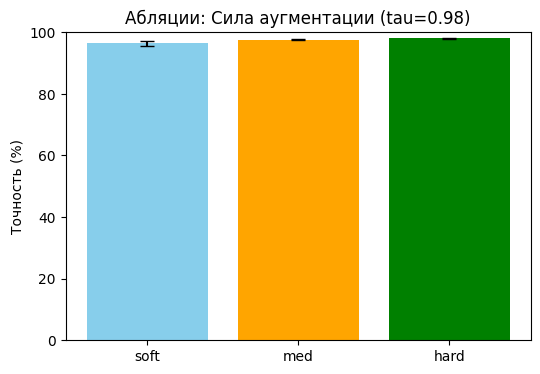

{'soft': {'acc_mean': np.float64(96.4), 'acc_std': np.float64(0.6929646455628193)}, 'med': {'acc_mean': np.float64(97.53), 'acc_std': np.float64(0.1979898987322341)}, 'hard': {'acc_mean': np.float64(98.0), 'acc_std': np.float64(0.18384776310849593)}}


In [35]:
results_ablation = ablation_augmentations(tau=0.98)
print(results_ablation)

Резельтаты {'soft': {'acc_mean': np.float64(96.4), 'acc_std': np.float64(0.6929646455628193)}, 'med': {'acc_mean': np.float64(97.53), 'acc_std': np.float64(0.1979898987322341)}, 'hard': {'acc_mean': np.float64(98.0), 'acc_std': np.float64(0.18384776310849593)}}